This example shows how to interpret anomalies in *tabular* data. 

To verify the effectiveness of DeepAID, we use a synthetic dataset here.

# Generate a synthetic dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
X.shape: (5050, 100)
perturb index: [25, 30, 40, 42, 47, 51, 58, 75, 78, 84]


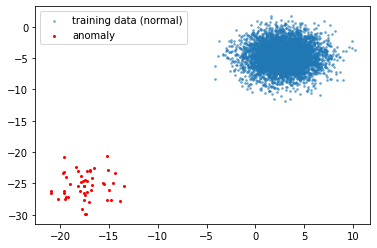

In [156]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import random 

# Generate Gaussian blobs (single cluster) consists 5050 100-dimension samples
X, _ = make_blobs(n_samples=5050, centers=1, n_features=100,
                  random_state=0, cluster_std=2.)
print('X.shape:',X.shape)

# first 5000 samples are used for training
X_train = X[:-50,:]

# generate anomalies by randomly perturbing 10 dimensions (1%) in the last 50 samples
random.seed(0)
noise_idx = random.choices(list(range(100)),k=10)
noise_idx.sort()
print('perturb index:',noise_idx)
noise_data = np.random.uniform(-20,-20,(50,10))
X_anomaly = X[-50:,:]
X_anomaly[:,noise_idx] += noise_data

# visualize anomaly and normal training data in 2D space 
X_train_plot = X_train[:, noise_idx]
pca = PCA(n_components=2).fit(X_train_plot)
plt.scatter(X_train_plot[:, 0], X_train_plot[:, 1], alpha=0.5, s=3, label="training data (normal)")
X_anomaly_plot = X_anomaly[:,noise_idx]
pca = PCA(n_components=2).fit(X_anomaly_plot)
plt.scatter(X_anomaly_plot[:, 0], X_anomaly_plot[:, 1], alpha=1., s=4, c="r", label="anomaly")
plt.legend()
plt.show()

# Prepare a DL model for anomaly detection

In [157]:
# Train an autoencoder-based DL model
import numpy as np
import torch
from autoencoder import train, test, test_plot
import sys
sys.path.append('../../deepaid/')
from utils import validate_by_rmse, Normalizer
normer = Normalizer(X_train.shape[-1],online_minmax=False)
X_train = normer.fit_transform(X_train)
model, thres = train(X_train, X_train.shape[-1])
torch.save({'net':model,'thres':thres},'./save/autoencoder.pth.tar')

epoch:0/0 |Loss: 0.2787609398365021
epoch:0/10 |Loss: 0.22375109791755676
epoch:0/20 |Loss: 0.1118699237704277
epoch:0/30 |Loss: 0.03729517385363579
epoch:1/0 |Loss: 0.022531993687152863
epoch:1/10 |Loss: 0.020533639937639236
epoch:1/20 |Loss: 0.01926310919225216
epoch:1/30 |Loss: 0.019083112478256226
epoch:2/0 |Loss: 0.018813330680131912
epoch:2/10 |Loss: 0.018843336030840874
epoch:2/20 |Loss: 0.018969206139445305
epoch:2/30 |Loss: 0.018715135753154755
epoch:3/0 |Loss: 0.01866218075156212
epoch:3/10 |Loss: 0.018574636429548264
epoch:3/20 |Loss: 0.018698981031775475
epoch:3/30 |Loss: 0.018576322123408318
epoch:4/0 |Loss: 0.018695330247282982
epoch:4/10 |Loss: 0.018740231171250343
epoch:4/20 |Loss: 0.018911510705947876
epoch:4/30 |Loss: 0.01862536557018757
max AD score 0.17036724
thres: 0.17036724


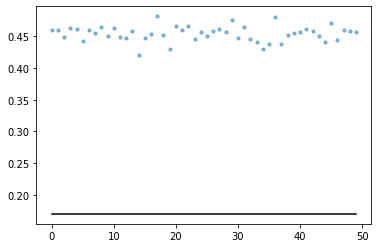

In [158]:
# Validate the performance of trained model
X_anomaly_norm = normer.transform(X_anomaly)
rmse_vec = test(model,thres,X_anomaly_norm)
test_plot(X_anomaly_norm, rmse_vec, thres) # ACC = 100%

# Interpret the generated anomalies

In [159]:
"""Load the model"""
from autoencoder import autoencoder
from utils import Normalizer
model_dict = torch.load('save/autoencoder.pth.tar')
model = model_dict['net']
thres = model_dict['thres']


""" Create a DeepAID Tabular Interpreter"""
import sys
sys.path.append("../../deepaid/interpreters/")
from tabular import TabularAID
my_interpreter = TabularAID(model,thres,input_size=100,k=10,steps=100,auto_params=False)

"""Interpret the anomalies"""
# for anomaly in X_anomaly:
anomaly = X_anomaly[5]
interpretation = my_interpreter(anomaly)
my_interpreter.show_table(anomaly,interpretation, normer) 

print('perturb index:',noise_idx)


Successfully Initialize <Tabular Interptreter> for Model <autoencoder>
 step:0 |Loss:90.3294 |loss1:90.3294 (dist:{90.3485} bound:{0.0190}) |loss2:0.0000 |L0:0.0000
 step:10 |Loss:79.6195 |loss1:79.6094 (dist:{79.6285} bound:{0.0190}) |loss2:10.0227 |L0:7.0000
 step:20 |Loss:72.0244 |loss1:72.0073 (dist:{72.0264} bound:{0.0190}) |loss2:17.0463 |L0:9.0000
 step:30 |Loss:66.2069 |loss1:66.1846 (dist:{66.2037} bound:{0.0190}) |loss2:22.2382 |L0:10.0000
 step:40 |Loss:61.4978 |loss1:61.4713 (dist:{61.4903} bound:{0.0190}) |loss2:26.5503 |L0:10.0000
 step:50 |Loss:57.6366 |loss1:57.6060 (dist:{57.6250} bound:{0.0190}) |loss2:30.5636 |L0:10.0000
 step:60 |Loss:54.4704 |loss1:54.4367 (dist:{54.4557} bound:{0.0190}) |loss2:33.6874 |L0:14.0000
 step:70 |Loss:51.7291 |loss1:51.6931 (dist:{51.7122} bound:{0.0190}) |loss2:35.9873 |L0:16.0000
 step:80 |Loss:49.3189 |loss1:49.2807 (dist:{49.2998} bound:{0.0190}) |loss2:38.1257 |L0:17.0000
 step:90 |Loss:47.1720 |loss1:47.1322 (dist:{47.1512} bound:{